### TODO
- Everything
- Drop users that have rated very few movies -> How to decide the threshold?
- Define the best approach to the collaborative filtering (model-based or memory-based)
- Build the recommender system (can it be as simple as kNN?)

### DONE
- File loading and creation of the DataFrame

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read Movie Titles file
def readMovieTitle(file_path):
    data_dict = {'Movie_Id' : [], 'Release_Year' : [], 'Title' : []}
    data_file = open(file_path, "r", encoding='ISO-8859-1')
    for line in data_file:            
        id, year, title = line.split(',', 2)
        data_dict['Movie_Id'].append(id)
        data_dict['Release_Year'].append(year)
        data_dict['Title'].append(title.rstrip('\n'))
    data_file.close()
            
    return pd.DataFrame(data_dict)

In [3]:
# The dataset is very large, so there's a flag to load only a handful of rows if necessary
# First 100k lines takes 0.2s to load, the whole dataset takes almost 2 minutes
def readFile(file_path, rows = 100000, flag = False):
    data_dict = {'Cust_Id' : [], 'Movie_Id' : [], 'Rating' : [], 'Date' : []}
    data_file = open(file_path, "r")
    count = 0
    for line in data_file:
        count += 1
        if flag and (count > rows):
            break
            
        if ':' in line:
            movidId = line[:-2] # remove the last character ':'
            movieId = int(movidId)
        else:
            customerID, rating, date = line.split(',')
            data_dict['Cust_Id'].append(customerID)
            data_dict['Movie_Id'].append(movieId)
            data_dict['Rating'].append(rating)
            data_dict['Date'].append(date.rstrip("\n"))
    data_file.close()
            
    return pd.DataFrame(data_dict)

In [4]:
# Load the title of the movies
df_title = readMovieTitle('data/movie_titles.csv')
df_title['Movie_Id'] = df_title['Movie_Id'].astype(int)
df_title.head(10)

,Movie_Id,Release_Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
5,6,1997,Sick
6,7,1992,8 Man
7,8,2004,What the #$*! Do We Know!?
8,9,1991,Class of Nuke 'Em High 2
9,10,2001,Fighter


In [5]:
df_title.loc[df_title['Movie_Id'] == '4500']

,Movie_Id,Release_Year,Title


In [6]:
# Loading the user data
# User ID, Movie ID, Rating and Date
flag_limit = True
df1 = readFile('data/combined_data_1.txt', flag = flag_limit)
df2 = readFile('data/combined_data_2.txt', flag = flag_limit)
df3 = readFile('data/combined_data_3.txt', flag = flag_limit)
df4 = readFile('data/combined_data_4.txt', flag = flag_limit)
df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

In [7]:
# Creation of the DataFrame with all the data
df = df1.copy()
df = pd.concat([df2, df3, df4])
df.index = np.arange(0,len(df))
df.head(10)

# Complete Dataframe with the movie titles
# Not necessary
df = df.merge(df_title, how='left')
df = df.loc[:, ['Cust_Id', 'Movie_Id', 'Title', 'Release_Year', 'Rating', 'Date']]
df.head(-10)

# Too much data, so I'm deleting the dataframes after the merge
# In total it uses 14gb of memory
del df1, df2, df3, df4

In [8]:
df.head(10)

,Cust_Id,Movie_Id,Title,Release_Year,Rating,Date
0,2532865,4500,Les Dames du Bois de Boulogne,1945,4.0,2005-07-26
1,573364,4500,Les Dames du Bois de Boulogne,1945,3.0,2005-06-20
2,1696725,4500,Les Dames du Bois de Boulogne,1945,3.0,2004-02-27
3,1253431,4500,Les Dames du Bois de Boulogne,1945,3.0,2004-03-31
4,1265574,4500,Les Dames du Bois de Boulogne,1945,2.0,2003-09-01
5,1049643,4500,Les Dames du Bois de Boulogne,1945,1.0,2003-11-15
6,1601348,4500,Les Dames du Bois de Boulogne,1945,4.0,2005-04-05
7,1495289,4500,Les Dames du Bois de Boulogne,1945,5.0,2005-07-09
8,1254903,4500,Les Dames du Bois de Boulogne,1945,3.0,2003-09-02
9,2604070,4500,Les Dames du Bois de Boulogne,1945,3.0,2005-05-15


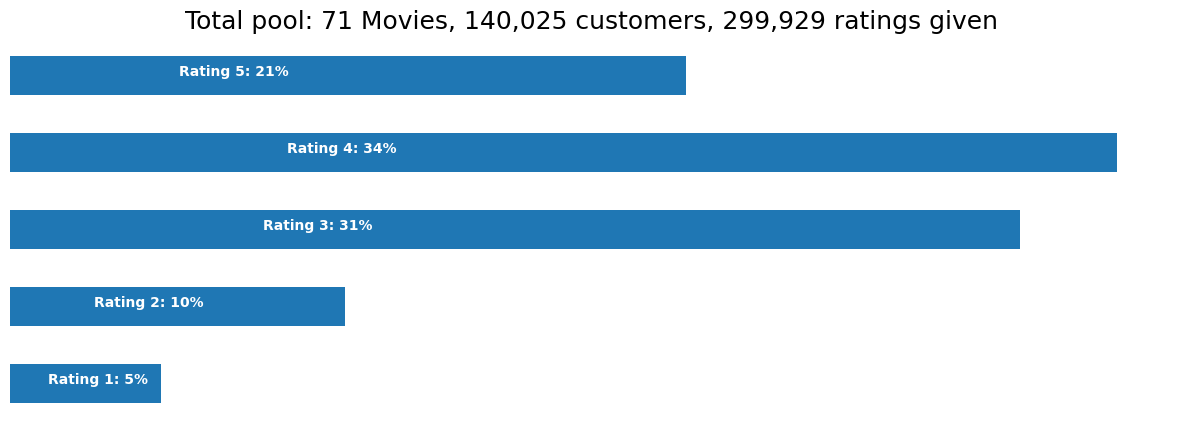

In [9]:
# Group the dataframe by ratings
ratings_df = df.groupby('Rating')['Rating'].agg(['count'])

# Number of unique movies
movie_count = df['Movie_Id'].nunique()

# Number of unique customers
cust_count = df['Cust_Id'].nunique()

# Number of ratings
rating_count = df['Cust_Id'].count()

ax = ratings_df.plot(kind = 'barh', legend = False, figsize = (15,5))

plt.title(f'Total pool: {movie_count} Movies, {cust_count:,} customers, {rating_count:,} ratings given', fontsize=18)
plt.axis('off')

for i in range(1,6):
    ax.text(ratings_df.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, ratings_df.iloc[i-1][0]*100 / ratings_df.sum()[0]), color = 'white', weight = 'bold')

68


array([[<AxesSubplot: title={'center': 'count'}>]], dtype=object)

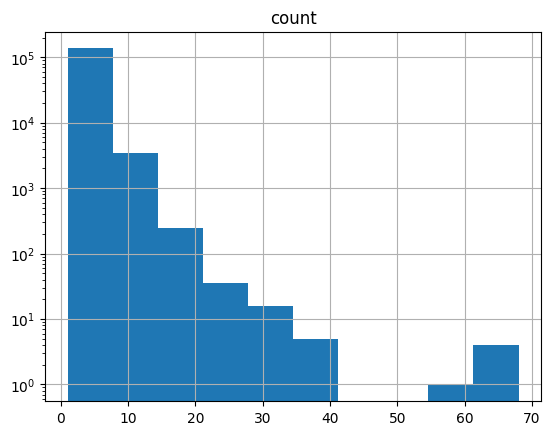

In [10]:
# Group users by the number of reviews
n_df = df.groupby('Cust_Id')['Rating'].agg(['count'])

print(n_df['count'].max())

n_df.hist(log=True)
